In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
import datetime as dt
from textblob import TextBlob
import gzip
import json
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import plotly.express as px
import warnings

### I) DATA ANALYSIS

a) Data Processing 

In [2]:
# Import Data
warnings.filterwarnings("ignore")
# Import dataframe
# We skipped on bad lines, because the bad lines are only present in 4 rows in our dataset
print("Num of Bad Lines in dataset:", len(pd.read_csv("books.csv",sep='delimiter')))
df = pd.read_csv("books.csv",on_bad_lines='skip')
print("Num of Lines after dropping bad lines:", len(df))

Num of Bad Lines in dataset: 11127
Num of Lines after dropping bad lines: 11123


In [3]:
# Inspect data
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [4]:
# Discovering data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


We can see from the table above that we have no null values in our data. 

Our features are split into different types:

* Non numerical : Title, Authors, isbn, language_code, publication_date, publisher
* Numerical : bookID, average_rating, isbn13, num_pages, ratings_count, text_reviews_count

Notice : publication_date should be a date data type instead of Object. So we need to convert it into a date.

In [5]:
# Trim num_pages
df.rename(columns={df.columns[7]:"num_pages"}, inplace=True)

In [6]:
# Checking for duplicates
df[df.drop("bookID",axis=1).duplicated() == True]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher


No duplicates were found

In [7]:
# Convert to date
# We have to fix some date errors before
df.iloc[8177,10] = '11/30/2000'
df.iloc[11094,10] =  '6/30/1982'
df["publication_date"] = pd.to_datetime(df["publication_date"], infer_datetime_format=True) 

b) Data Cleaning

In [8]:
# The column author needs to be cleaned if we want to operate some analysis on it. We'll extract the first full name of the author in column where names are sperated by "/"
print("Pct of Authors sep by /:", round(df[df["authors"].str.contains("/") == True].shape[0] / len(df),2)*100, "%")
df["Author"] = df["authors"].apply(lambda x: x.split('/')[0])
df.head(2)

Pct of Authors sep by /: 41.0 %


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Author
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,J.K. Rowling
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,J.K. Rowling


In [9]:
# Same data cleaning for title
print("Pct of Authors sep by /:", round(df[df["title"].str.contains("/") == True].shape[0] / len(df),2)*100, "%")
df["title"] = df["title"].apply(lambda x: x.split('/')[0])
df.head(2)

Pct of Authors sep by /: 2.0 %


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Author
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,2006-09-16,Scholastic Inc.,J.K. Rowling
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,2004-09-01,Scholastic Inc.,J.K. Rowling


c) EDA

1) Analyzing Numerical Features

- Distribution of numerical features

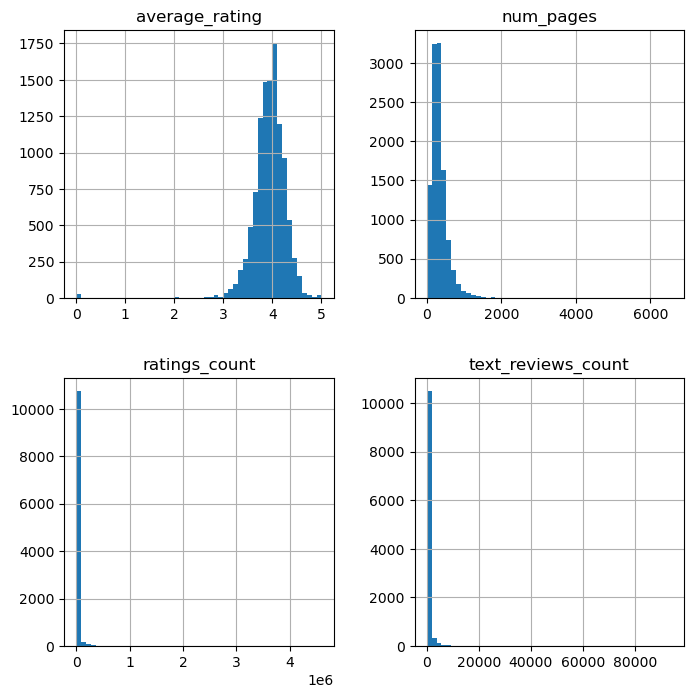

In [10]:
# Checking the distributions 
numericals = [col for col in df if df[col].dtype != "O" and col not in ["bookID", "isbn13", "publication_date"]]
df[numericals].hist(figsize = (8,8), bins = 50)
plt.show()

- Descriptive stats

In [11]:
df[numericals].describe()

,average_rating,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,3.934075,336.405556,1.794285e+04,542.048099
std,0.350485,241.152626,1.124992e+05,2576.619589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,47.000000
75%,4.140000,416.000000,5.000500e+03,238.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


From this table, we can observe that on average books get 3.96. But we can also see that there books with 0 as an average rating. This should push us to investigate further about those books in our dataset and see if it's a missing data or some error. 

In [12]:
# Data investigation 
zero_books = df[df['average_rating'] == 0]
print("Length of DataFrame:", len(zero_books))
zero_books.sample(3)

Length of DataFrame: 25


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Author
6859,25841,The Road To War 1933 39,Andrew Hunt,0.0,0340774770,9780340774779,eng,128,0,0,2000-04-01,Hodder & Stoughton Educational Division,Andrew Hunt
10138,41044,Day and Night,Better Homes and Gardens,0.0,0696018829,9780696018824,eng,32,0,1,1989-03-01,Meredith Corporation,Better Homes and Gardens
6380,24010,"Laguna I Love You: The Best of ""Our Town""",John Weld/Phil Interlandi,0.0,1564741575,9781564741578,eng,285,0,0,1996-03-01,Fithian Press,John Weld


We can see that some books have gotten no reviews. This is the reason why these books have an average_rating of Zero. Since our goal here is to build a ML model that will help us predict the rating of a book. This data is kind of useless for us and since this portion of data represents only a small fraction of the whole dataset, we choose to simply drop this data from our dataset. 

In [13]:
# Find rows to drop 
row_to_drop = zero_books.index
# Drop rows
df = df.drop(row_to_drop)

- Outliers Analysis

In [14]:
fig = px.box(df[numericals], log_y=True)
fig.show()   

* Average_Rating : We can notice that virtually all ratings are between 3 and 5. But we can observe that this dat has many outliers. 
* Num_pages : Most books are below 500 Pages with some expections going far beyond 1000 Pages. 
* Ratings_count = Most books have number of ratings ranging from about 100 to 5000. 
* Text_reviews_count : Most books got between around 9 and 600 reviews 

- Correlations

<AxesSubplot:>

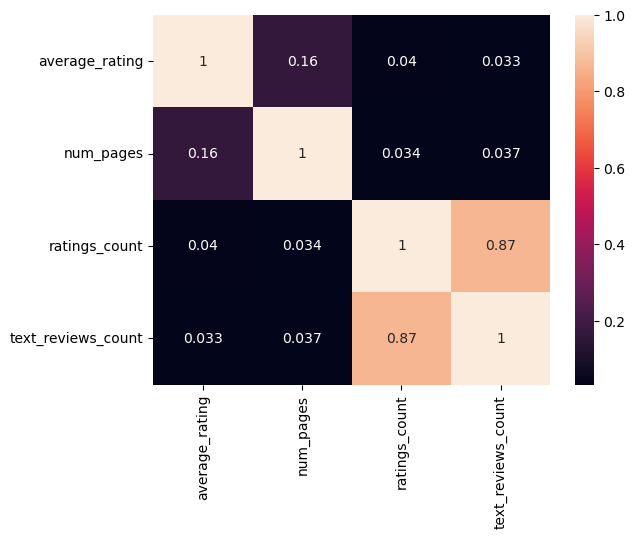

In [15]:
sns.heatmap(df.drop(["bookID", "isbn13", "isbn"], axis=1).corr(),annot=True)

Num_pages is the only numerical feature that's slighly correlated to the target. Other numercial features have almost no relationship with average rating. 

2) Analyzing non-numericals features

In [16]:
categoricals = [col for col in df.columns if col not in numericals and col not in ["bookID", "isbn", "isbn13", "publication_date"]]
categoricals

['title', 'authors', 'language_code', 'publisher', 'Author']

- What are the TOP 10 rated books (using weighted average technique)

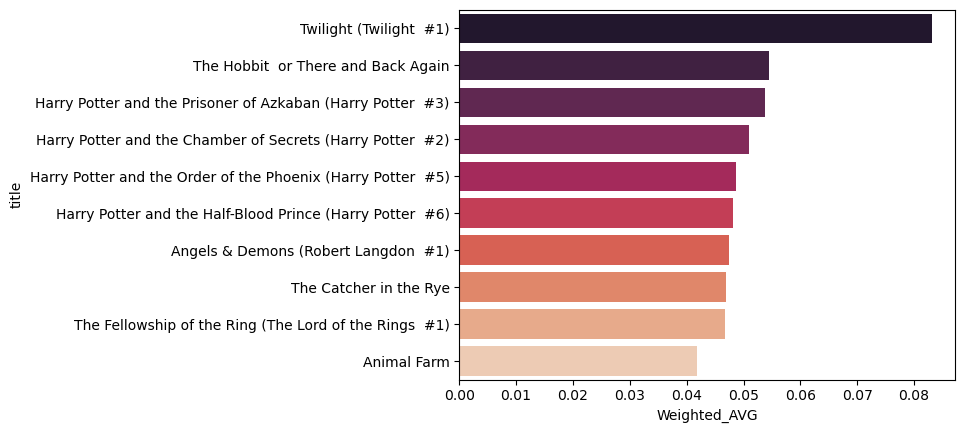

In [17]:
# Weighted_average by title
groupedbyWA = df.groupby("title").agg({"average_rating":"mean", "ratings_count":"max"})
groupedbyWA["Weighted_AVG"] = round((groupedbyWA.average_rating * (groupedbyWA.ratings_count + 0.001)) / (groupedbyWA.ratings_count.sum()), 4)
TOP10_Books = groupedbyWA.sort_values(by="Weighted_AVG", ascending=False)[:10]
axs = sns.barplot(x=TOP10_Books["Weighted_AVG"] , y=TOP10_Books.index , data=TOP10_Books, palette='rocket')

- Who are the highest/lowest rated publishers and their first publication date?

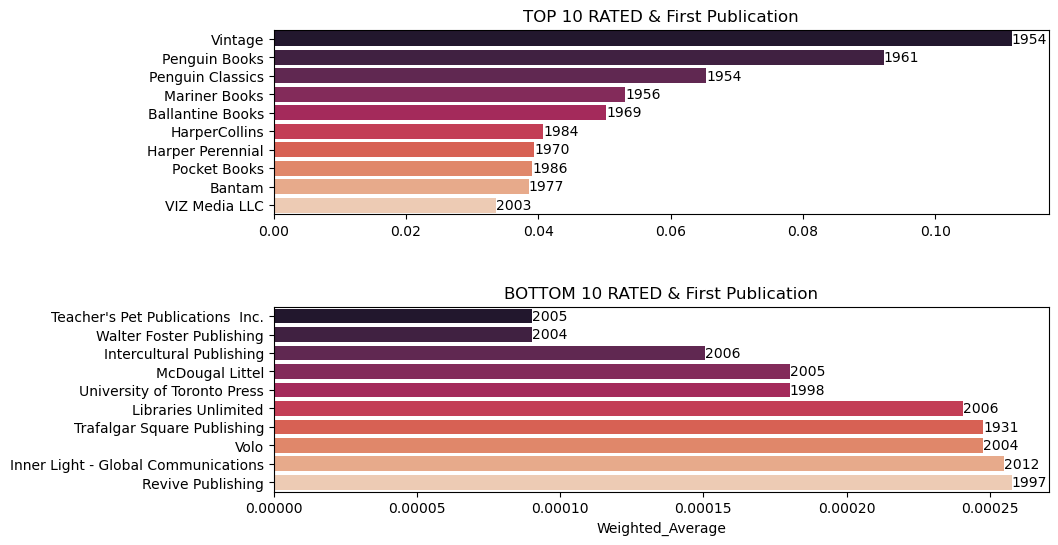

In [18]:
# Let's see the frequency of publications by publisher and use it to calculate a weighted average
publisher_frequency = df.groupby("publisher").agg({'average_rating': ['mean'], 
                        'publisher': ['count'], 'publication_date':'min'}).sort_values(by=[('average_rating','mean'), ('publisher','count')])
publisher_frequency["Weighted_Average"] = publisher_frequency[('average_rating','mean')] * publisher_frequency[('publisher','count')] / len(df)
# Vizualize results
TOP_10_publisher = publisher_frequency.sort_values(by="Weighted_Average", ascending=False)[:10]
BOTTOM_10_publisher = publisher_frequency.sort_values(by="Weighted_Average")[:10]
fig, axs = plt.subplots(2,1, figsize=(10, 6), facecolor='w', edgecolor='k', sharey=False)
sns.barplot(x=TOP_10_publisher["Weighted_Average"] , y=TOP_10_publisher.index , data=TOP_10_publisher, ax=axs[0],palette='rocket')
sns.barplot(x=BOTTOM_10_publisher["Weighted_Average"] , y=BOTTOM_10_publisher.index , data=BOTTOM_10_publisher, ax=axs[1],palette='rocket')
axs[0].set_xlabel("")
# axs[0].legend(TOP_10_publisher[('publication_date','min')].dt.year)
# axs[1].legend(BOTTOM_10_publisher[('publication_date','min')].dt.year)
axs[0].set_title("TOP 10 RATED & First Publication")
axs[1].set_title("BOTTOM 10 RATED & First Publication")
axs[0].set_ylabel("")
axs[1].set_ylabel("")
# Add annotations
for i, (value, year) in enumerate(zip(TOP_10_publisher["Weighted_Average"], TOP_10_publisher[('publication_date','min')].dt.year)):
    axs[0].text(value, i, str(year), va='center')
for i, (value, year) in enumerate(zip(BOTTOM_10_publisher["Weighted_Average"], BOTTOM_10_publisher[('publication_date','min')].dt.year)):
    axs[1].text(value, i, str(year), va='center')
plt.subplots_adjust(hspace=0.5)

We can observe from this chart that the TOP 10 rated publishers are quite old on average compared to the Bottom 10. 

- What are the oldest and most recent publishers?

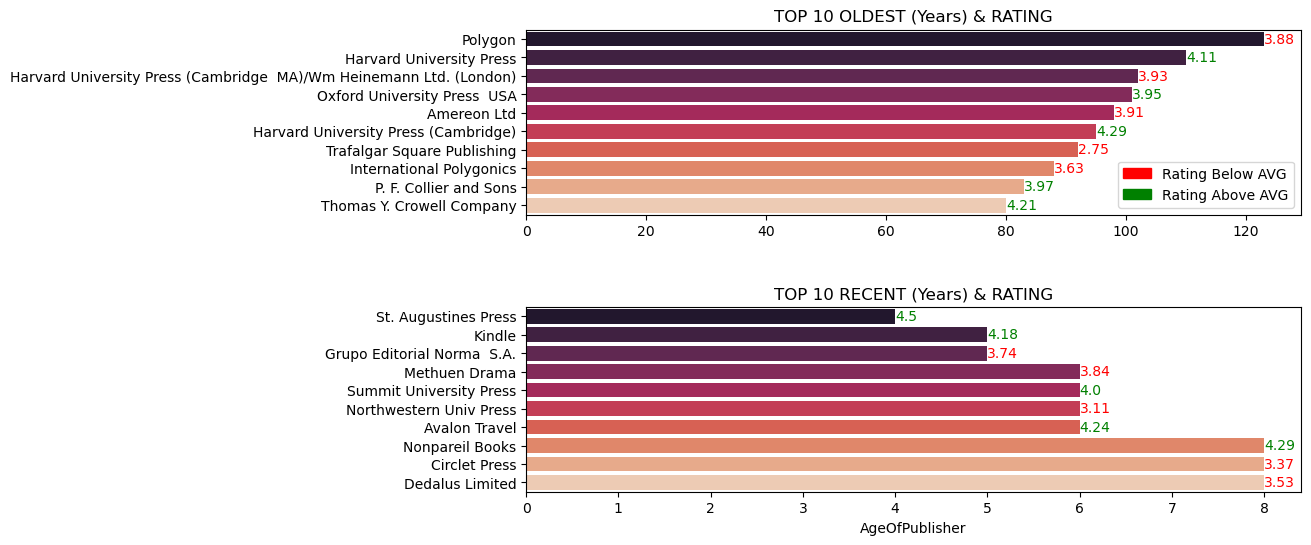

In [19]:
# Calculate age of publisher
publisher_frequency["AgeOfPublisher"] = dt.date.today().year - publisher_frequency[('publication_date', 'min')].dt.year
# Vizualize results
global_mean = df["average_rating"].mean()

TOP_10_Old_publisher = publisher_frequency.sort_values(by="AgeOfPublisher", ascending=False)[:10]
TOP_10_Recent_publisher = publisher_frequency.sort_values(by="AgeOfPublisher")[:10]
fig, axs = plt.subplots(2,1, figsize=(10, 6), facecolor='w', edgecolor='k', sharey=False)
sns.barplot(x=TOP_10_Old_publisher["AgeOfPublisher"] , y=TOP_10_Old_publisher.index , data=TOP_10_Old_publisher, ax=axs[0],palette='rocket')
sns.barplot(x=TOP_10_Recent_publisher["AgeOfPublisher"] , y=TOP_10_Recent_publisher.index , data=TOP_10_Recent_publisher, ax=axs[1],palette='rocket')
axs[0].set_xlabel("")
# axs[0].legend(TOP_10_publisher[('publication_date','min')].dt.year)
# axs[1].legend(BOTTOM_10_publisher[('publication_date','min')].dt.year)
axs[0].set_title("TOP 10 OLDEST (Years) & RATING")
axs[1].set_title("TOP 10 RECENT (Years) & RATING")
axs[0].set_ylabel("")
axs[1].set_ylabel("")
# Add annotations
for i, (value, year) in enumerate(zip(TOP_10_Old_publisher[('average_rating','mean')],TOP_10_Old_publisher["AgeOfPublisher"])):
    color = 'red' if value < global_mean else 'green'
    axs[0].text(year, i, str(round(value,2)), va='center', color=color)
for i, (value, year) in enumerate(zip(TOP_10_Recent_publisher[('average_rating','mean')], TOP_10_Recent_publisher["AgeOfPublisher"])):
    color = 'red' if value < global_mean else 'green'
    axs[1].text(year, i, str(round(value,2)), va='center', color=color)
red_patch = mpatches.Patch(color='red', label='Rating Below AVG')
green_patch = mpatches.Patch(color='green', label='Rating Above AVG')
axs[0].legend(handles=[red_patch, green_patch], loc='best')
plt.subplots_adjust(hspace=0.5)

In [20]:
print(f"Average_rating for old publishers is: {TOP_10_Old_publisher.average_rating.mean()}")
print("Average_rating for recent publishers is:", TOP_10_Recent_publisher.average_rating.mean())


Average_rating for old publishers is: mean    3.863323
dtype: float64
Average_rating for recent publishers is: mean    3.88
dtype: float64


Being an old publisher doesn't seem to translate into a more likelihood of getting good ratings.

- Is frequency of publication related to average rating?

Pearson Corr Coef: -0.011691271636482162


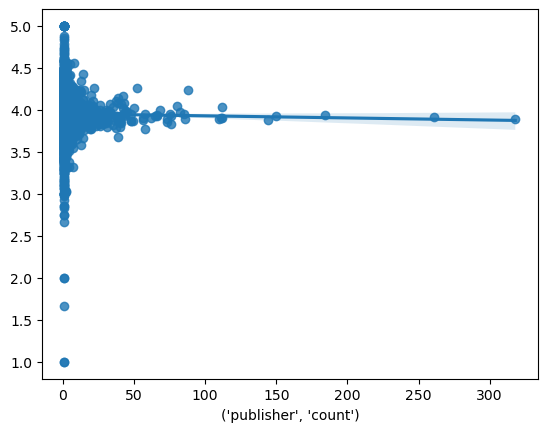

In [21]:
sns.regplot(x=publisher_frequency[('publisher', 'count')], y=publisher_frequency[('average_rating', 'mean')].values  ,data=publisher_frequency)
# calculate the R-coefficient
r, _ = stats.pearsonr(publisher_frequency[('publisher', 'count')], publisher_frequency[('average_rating', 'mean')].values)

# add the R-coefficient to the plot
print("Pearson Corr Coef:", r)


It doesn't seem that way.

- Who are the TOP10 Highest/Lowest rated authors and their number of publications?

Text(0.5, 1.0, 'Number of Books they published')

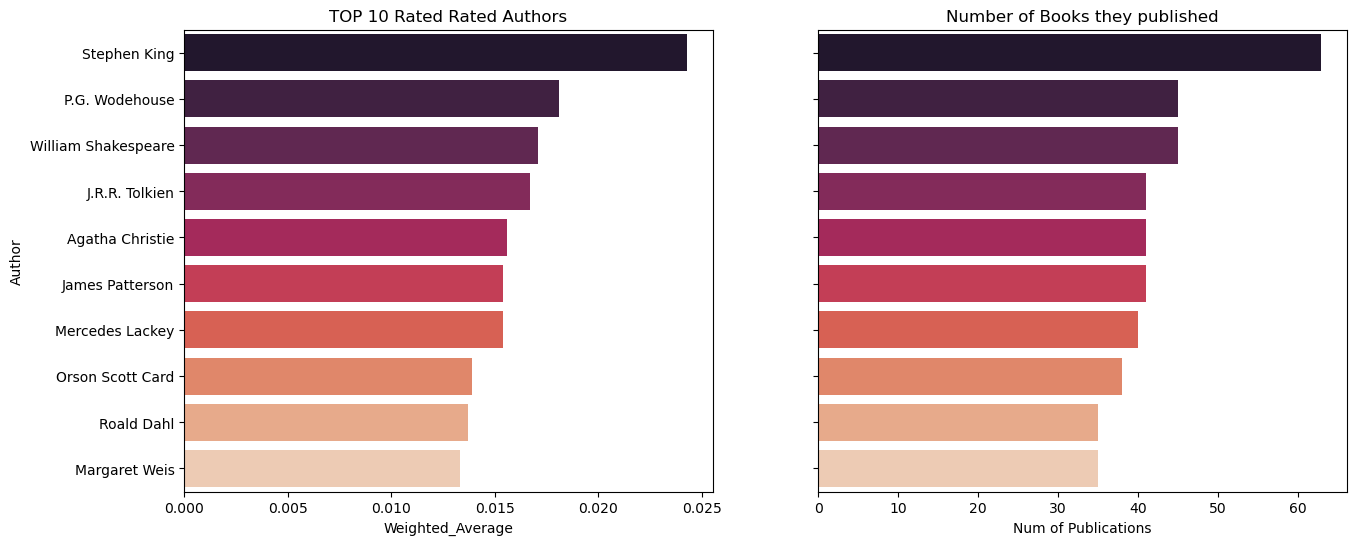

In [22]:
# Lowest/Highest rated authors
df["Author"] = df["authors"].apply(lambda x: x.split('/')[0])
MostPublishedAuthors = df.groupby("Author").agg({"title":"nunique", "average_rating":"mean"}).sort_values(by="title", ascending=False)
MostPublishedAuthors["Weighted_Average"] = round((MostPublishedAuthors.title * MostPublishedAuthors.average_rating) / MostPublishedAuthors.title.sum(),4)

TOP_10_authors = MostPublishedAuthors.sort_values(by="Weighted_Average", ascending=False)[:10]
mostBooks = MostPublishedAuthors.sort_values(by="title", ascending=False)[:10]

# BOTTOM_10_athors = MostPublishedAuthors.sort_values(by="Weighted_Average")[:10]
fig, axs = plt.subplots(1,2, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True)
sns.barplot(x=TOP_10_authors["Weighted_Average"] , y=TOP_10_authors.index , data=TOP_10_authors, palette='rocket',ax=axs[0])
sns.barplot(x=mostBooks["title"] , y=mostBooks.index , data=mostBooks, palette='rocket', ax=axs[1])
axs[1].set_xlabel("Num of Publications")
axs[1].set_ylabel("")
axs[0].set_title("TOP 10 Rated Rated Authors")
axs[1].set_title("Number of Books they published")
# plt.subplots_adjust(wspace=0.5)

TOP rated authors tend to publish more books than average and it kind of makes sense as famous authors usually publish more than one book.

- What's the most common number of books an author might publish during their career ?

Text(16, 0.8, '99% of authors have published up to 10 books.')

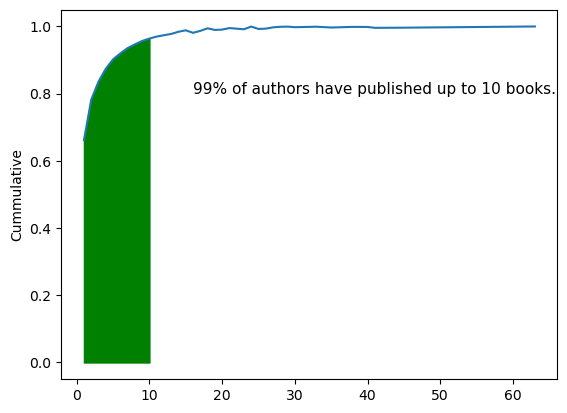

In [23]:
running_totals = pd.DataFrame(MostPublishedAuthors.title.value_counts(ascending=False, normalize=True))
running_totals["Cummulative"] = running_totals["title"].cumsum()
ax = sns.lineplot(x=running_totals.index, y="Cummulative", data=running_totals)
a=np.arange(1,len(running_totals)+1)
b=running_totals["Cummulative"]
plt.fill_between(a, b, 0,
                 where = (a >= 0) & (a <= 10),
                 color = 'g')
ax.text(16, 0.80, """99% of authors have published up to 10 books.""", fontsize=11)

Virtually all authors in our dataset have published up to 10 books.

- What's the average rating through time?

<AxesSubplot:xlabel='publication_date'>

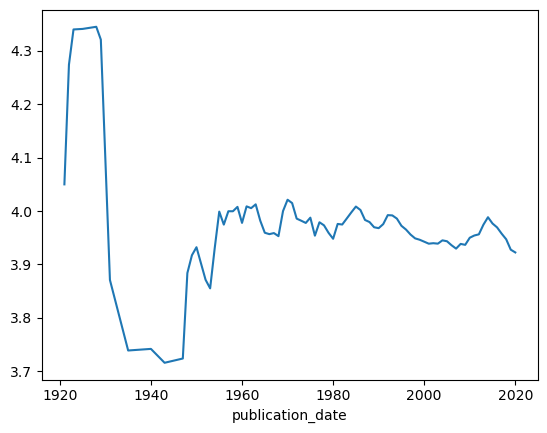

In [24]:
# We might ask ourselves how the average_rating changed over time
RatingOverTime = df.groupby(df["publication_date"].dt.year).agg({"average_rating":"mean", "title":"count"})
# Compute weighted_average
RatingOverTime["Weighted_AVG"] = round((RatingOverTime["average_rating"] * RatingOverTime.title) / RatingOverTime.title.sum(),4)
# Add 5 Year Rolling average to make vizualization easier to read
RatingOverTime['Rolling Average'] = round(RatingOverTime['average_rating'].rolling(window=5).mean(),5)
RatingOverTime['Rolling Weighted_Average'] = round(RatingOverTime['Weighted_AVG'].rolling(window=5).mean(),5)

sns.lineplot(x=RatingOverTime.index, y=RatingOverTime['Rolling Average'].values  ,data=RatingOverTime)

- What are the TOP/Bottom 10 Rated years

Text(0.5, 1.0, 'Bottom 10 Rated Years')

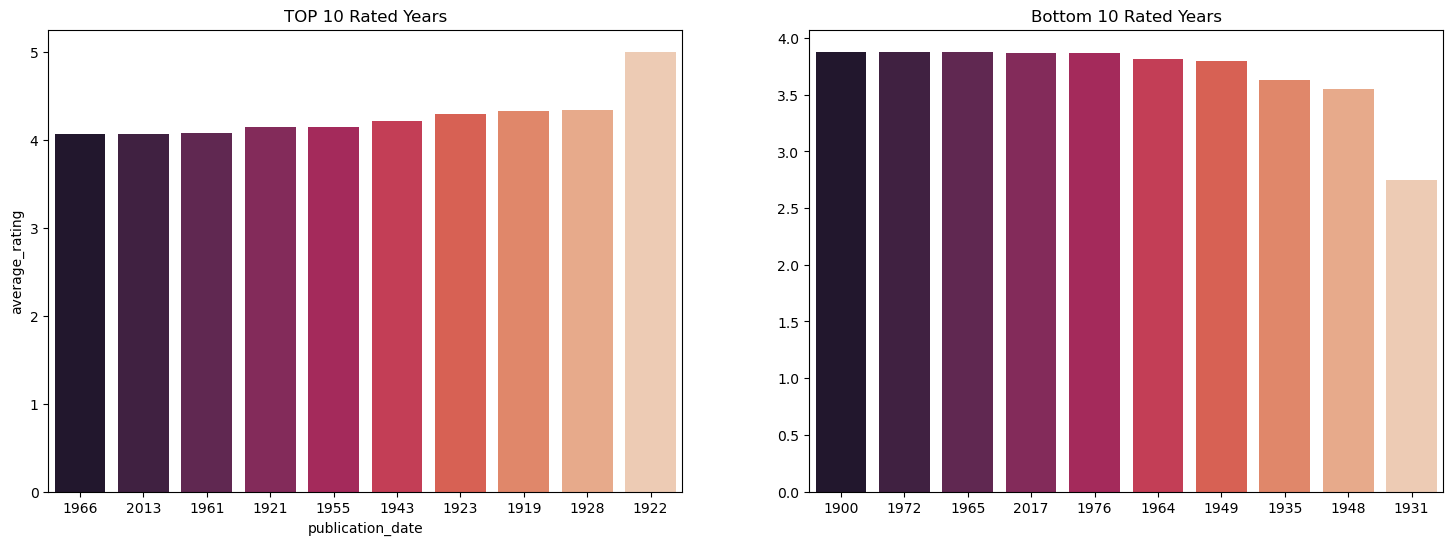

In [25]:
TOP_10_rating_year = RatingOverTime.sort_values(by="average_rating", ascending=False)[:10]
BOTTOM_10_rating_year = RatingOverTime.sort_values(by="average_rating")[:10]

# BOTTOM_10_athors = MostPublishedAuthors.sort_values(by="Weighted_Average")[:10]
fig, axs = plt.subplots(1,2, figsize=(18, 6), facecolor='w', edgecolor='k', sharey=False)
sns.barplot(x=TOP_10_rating_year.index, y="average_rating" , data=TOP_10_rating_year, palette='rocket',ax=axs[0],order=TOP_10_rating_year.index[::-1])
sns.barplot(x=BOTTOM_10_rating_year.index, y="average_rating" , data=BOTTOM_10_rating_year, palette='rocket', ax=axs[1],order=BOTTOM_10_rating_year.index[::-1])
axs[1].set_xlabel("")
axs[1].set_ylabel("")
axs[0].set_title("TOP 10 Rated Years")
axs[1].set_title("Bottom 10 Rated Years")

- What are the Most Rated, Reviewed and Engaging Books?

PS : We mean by Engaing book, a book that gets a considerable amount of reviews out of all ratings.

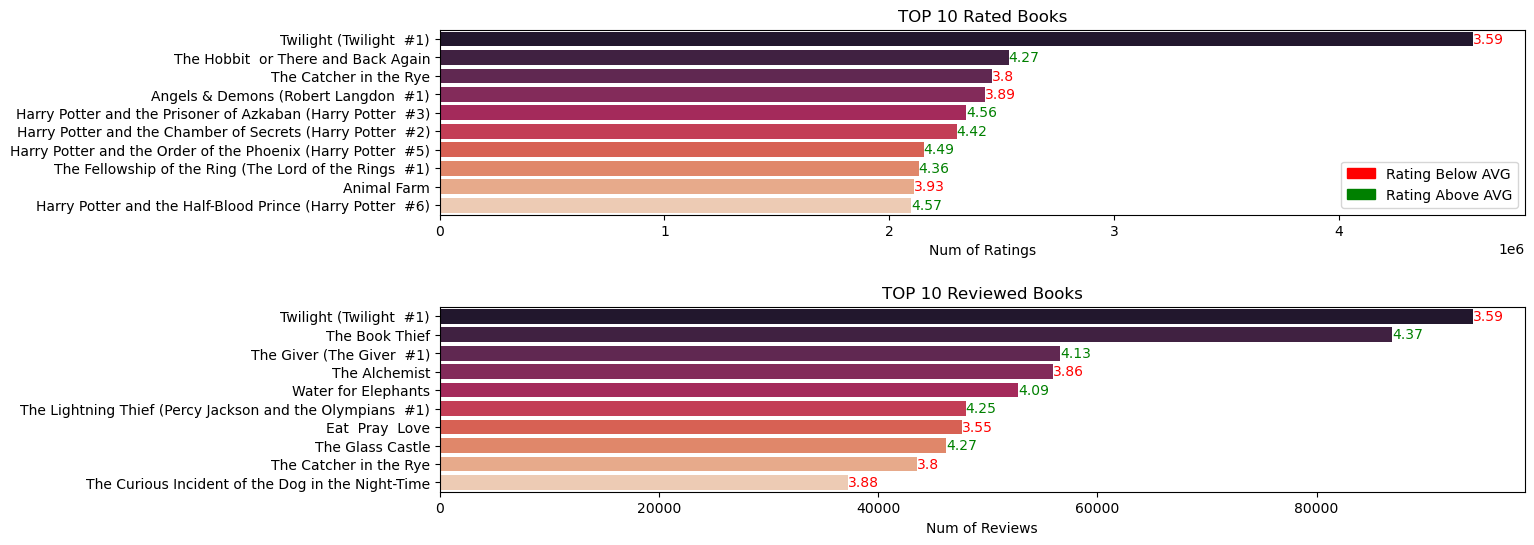

In [26]:
most_reviewed_rated_books = df.groupby("title").agg({"text_reviews_count":"sum", "ratings_count":"sum", "average_rating":"max"})
most_rated_books = most_reviewed_rated_books.sort_values(by="ratings_count", ascending=False)[:10]
most_reviewed_books = most_reviewed_rated_books.sort_values(by="text_reviews_count", ascending=False)[:10]

# BOTTOM_10_athors = MostPublishedAuthors.sort_values(by="Weighted_Average")[:10]
fig, axs = plt.subplots(2,1, figsize=(14, 6), facecolor='w', edgecolor='k', sharey=False)
sns.barplot(x="ratings_count" , y=most_rated_books.index , data=most_rated_books, palette='rocket',ax=axs[0])
sns.barplot(x="text_reviews_count" , y=most_reviewed_books.index , data=most_reviewed_books, palette='rocket', ax=axs[1])
axs[0].set_xlabel("Num of Ratings")
axs[1].set_xlabel("Num of Reviews")
axs[1].set_ylabel("")
axs[0].set_ylabel("")
axs[0].set_title("TOP 10 Rated Books")
axs[1].set_title("TOP 10 Reviewed Books")

# Add annotations
for i, (value, value2) in enumerate(zip(most_rated_books['average_rating'], most_rated_books["ratings_count"])):
    color = 'red' if value < global_mean else 'green'
    axs[0].text(value2, i, str(round(value,2)), va='center', color=color)

for i, (value, value2) in enumerate(zip(most_reviewed_books['average_rating'], most_reviewed_books["text_reviews_count"])):
    color = 'red' if value < global_mean else 'green'
    axs[1].text(value2, i, str(round(value,2)), va='center', color=color)
red_patch = mpatches.Patch(color='red', label='Rating Below AVG')
green_patch = mpatches.Patch(color='green', label='Rating Above AVG')
axs[0].legend(handles=[red_patch, green_patch], loc='best')
plt.subplots_adjust(hspace=0.5)

Not all people who rate a book leave a review. We will then study the relationship between Engagement_Rate which is simply the number of reviews divided by number of ratings each book has.

- Engagement_Rate VS Average_Rating

Correlation between Engagement_Rate and Average_Rating:
-0.19790765195639126


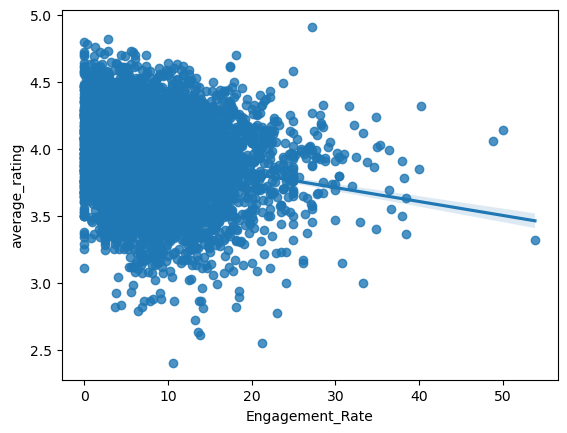

In [27]:
most_reviewed_rated_books["Engagement_Rate"] = round(most_reviewed_rated_books.text_reviews_count / (most_reviewed_rated_books.ratings_count + 0.001)  * 100,2 )
# Filter for books that got more than 10 ratings
t = most_reviewed_rated_books[most_reviewed_rated_books["ratings_count"]>10].sort_values(by="Engagement_Rate", ascending=False)
sns.regplot(x="Engagement_Rate", y="average_rating", data=t)
print("Correlation between Engagement_Rate and Average_Rating:")
r, _ = stats.pearsonr(t.Engagement_Rate, t['average_rating'].values)
print(r)

Surprisingly the more engaging a book is, the less likely it will get a good review; Although this relationship is very weak, it's an interesting finding. We will use this feature later in the feature engineering part.

- What is the Language distribution ? 

In [28]:
# Number of Languages 
fig = px.bar(df, x=df['language_code'].unique(), y=df['language_code'].value_counts())
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

English is by far the dominant language in our dataset. This could cause a biased model since the model will be mostly trained on English books.

- Is averaing rating different among languages?

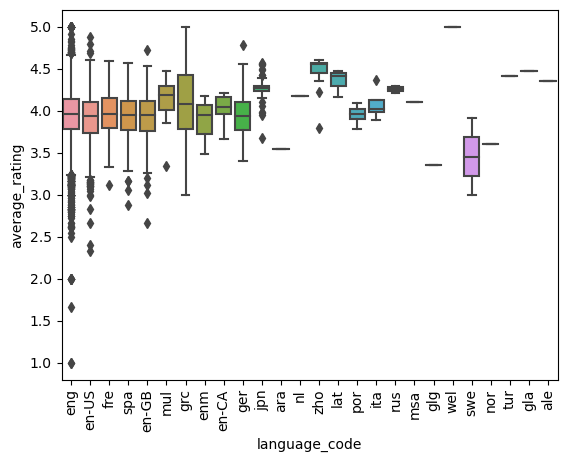

In [29]:
# Is average_rating different among types of languages
sns.boxplot(data=df, x="language_code", y="average_rating")
plt.xticks(rotation=90)
plt.show()


We can see some differences between languages in terms of average_rating but since our dataset mostly contains English books, these differences are quite not significant.

Text(0.5, 1.0, 'Average_rating for  English Books')

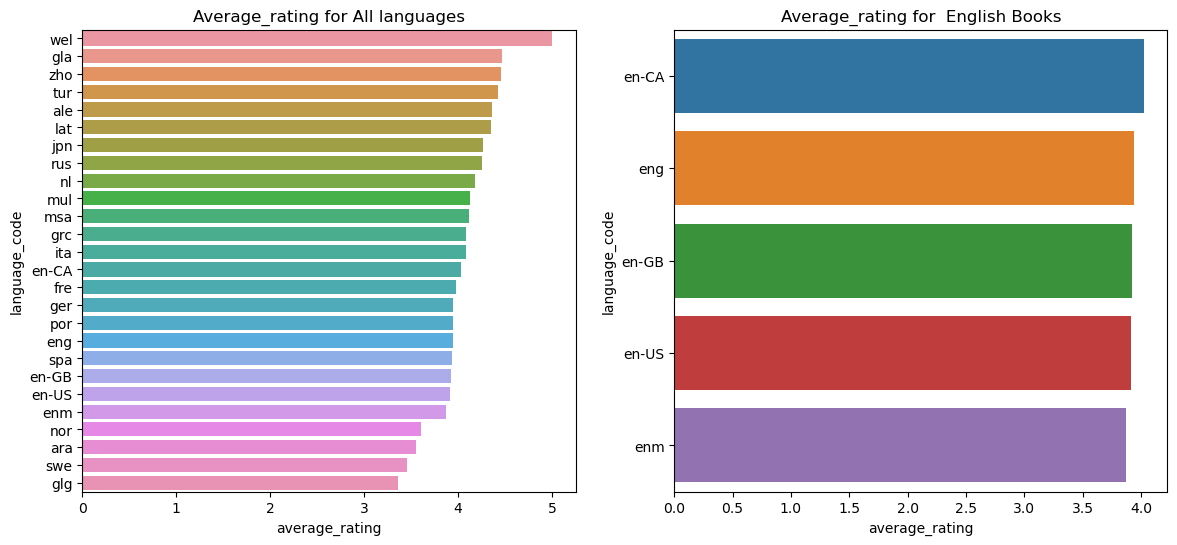

In [30]:
# As we saw during EDA, languages do seem to have an impact on averag_rating. Let's see this more in detail
fig, axs = plt.subplots(1,2, figsize=(14, 6), facecolor='w', edgecolor='k', sharey=False)
AVGRatingByLang = df.groupby("language_code").agg({"average_rating":"mean"}).reset_index().sort_values(by="average_rating",ascending=False)
AVGRatingByLangENG = AVGRatingByLang[AVGRatingByLang["language_code"].str.contains("en") == True]
sns.barplot(data=AVGRatingByLang, y="language_code", x="average_rating", ax=axs[0])
sns.barplot(data=AVGRatingByLangENG, y="language_code", x="average_rating", ax=axs[1])
axs[0].set_title("Average_rating for All languages")
axs[1].set_title("Average_rating for  English Books")

The difference in average ratings among English books is almost null, while the difference among other languages is quite considerable.

- Books with longest/Shortest titles

Text(0.5, 1.0, 'Number of Books they published')

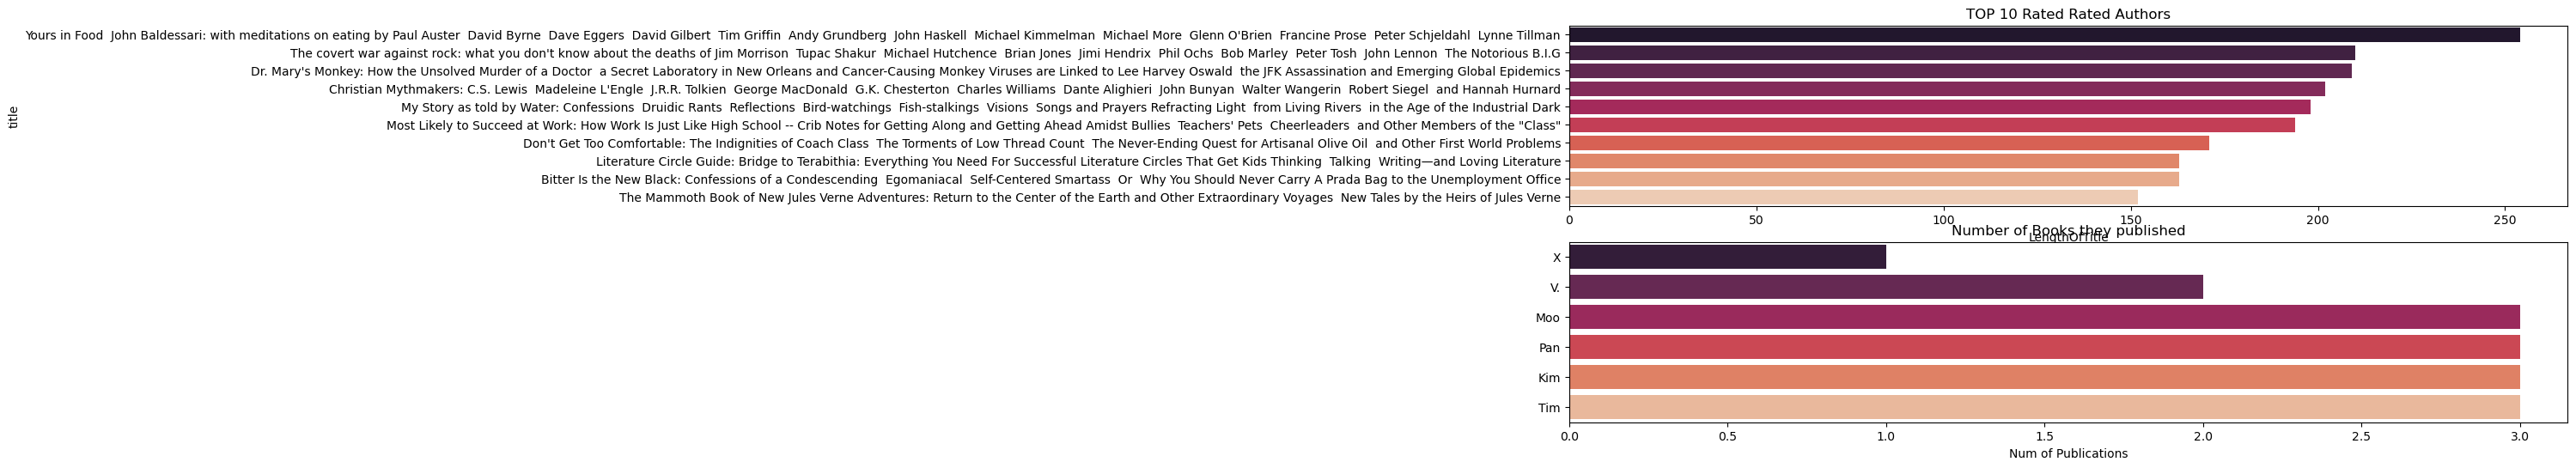

In [31]:
titleLength = df[["title", "average_rating"]]
titleLength["LengthOfTitle"] = titleLength["title"].apply(len)

TOP_Longest_titles = titleLength.sort_values(by="LengthOfTitle", ascending=False)[:10]
TOP_Shortest_titles = titleLength.sort_values(by="LengthOfTitle")[:10]

fig, axs = plt.subplots(2,1, figsize=(15, 6), facecolor='w', edgecolor='k', sharey=False)
sns.barplot(x="LengthOfTitle" , y="title" , data=TOP_Longest_titles, palette='rocket',ax=axs[0])
sns.barplot(x="LengthOfTitle" , y="title" , data=TOP_Shortest_titles, palette='rocket', ax=axs[1])
axs[1].set_xlabel("Num of Publications")
axs[1].set_ylabel("")
axs[0].set_title("TOP 10 Rated Rated Authors")
axs[1].set_title("Number of Books they published")

Correlation between LengthOfTitle and Average_Rating:
0.12387281670686327


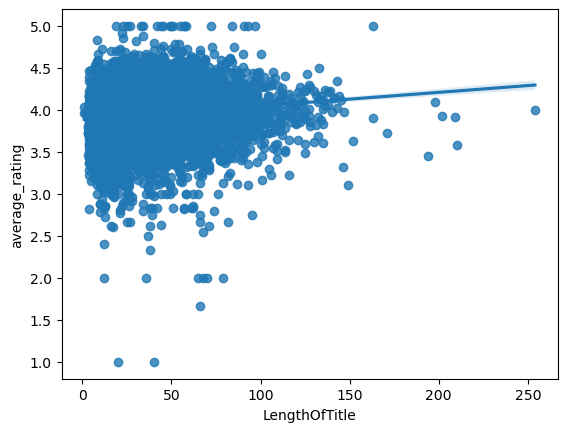

In [32]:
# Link between length of title and average_rating
sns.regplot(x="LengthOfTitle", y="average_rating", data=titleLength)
print("Correlation between LengthOfTitle and Average_Rating:")
r, _ = stats.pearsonr(titleLength.LengthOfTitle, titleLength['average_rating'].values)
print(r)

It appears that books with long titles are a bit more likely to get higher ratings. This could be a good feature to add in our model in the feature engineering part.

D) Feature Selection

1) Feature Engineering

We're going to use the findings from EDA and some thought experiments in order to create some features that might help us predict the average_rating better. As we saw earlier, most numerical features are not highly correlated if not at all correlated with our target variable average_rating, this will pose a real challenge for training our model later on. In this step, we're going to test some hypotheses and if these ones turn out to be true then we might consider adding these features to our dataset. The strategy of future prunning we're going to follow is quite simple, for numerical features if these one are not quite strongly correlated with the target then we don't add them to our model, same thing with categorical features.

- Are books with series more likely to get a higher average rating?

We observe that some book title contain # which means that this book is part of a series, we will create a new column that outputs True if the book is in a series or not. We predict that book that are part of a series might be more popular hence get a higher rating. 


In [33]:
df['IsBookSeries'] = df['title'].astype(str).str.contains('#', na=False)
df['IsBookSeries'] = df['IsBookSeries'].map({True: 1, False: 0})

In [34]:
# Series books
df.IsBookSeries.value_counts()

0    8747
1    2351
Name: IsBookSeries, dtype: int64

IsBookSeries
0    3.933232
1    3.979047
Name: average_rating, dtype: float64


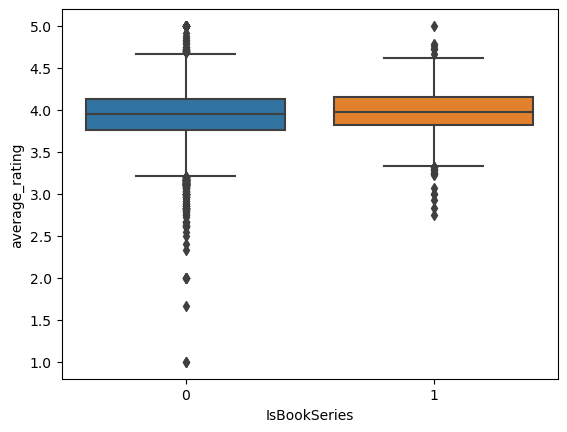

In [35]:
sns.boxplot(data=df, y="average_rating", x="IsBookSeries")
avg_by_series = df.groupby("IsBookSeries")["average_rating"].mean()
print(avg_by_series)

It does seem that books with series have slightly better average_ratings than those without but this difference is quite negligable.

- Languages 

We have seen in the EDA part, that English books are the most frequent books in our dataset and that the differences in average ratings among the English types is not significant. So, we're going to group all the English books into one category and leave other languages, while encoding the languages with very few occurances to other.

In [36]:
df.language_code.value_counts(ascending=False)

eng      8885
en-US    1408
spa       218
en-GB     214
fre       144
ger        99
jpn        46
mul        19
zho        14
grc        10
por        10
en-CA       7
ita         5
enm         3
lat         3
swe         2
rus         2
nl          1
msa         1
glg         1
wel         1
ara         1
nor         1
tur         1
gla         1
ale         1
Name: language_code, dtype: int64

In [37]:
df.loc[df[df["language_code"].str.contains("en")].index, "language_code"] = "ENG"
df['language_code'] = np.where(df['language_code'].isin(["spa", "fre", "ger", "ENG"]), df['language_code'], 'other')
df["LenOFTitle"] = df.title.apply(lambda x: len(x) if x else x)

In [38]:
df.language_code.value_counts(ascending=False)

ENG      10517
spa        218
fre        144
other      120
ger         99
Name: language_code, dtype: int64

- Length of title :
We saw in the EDA part that the length of a book title is positively but weakly correalted to average_rating so we create a new feature called length of title.

In [39]:
df["LenOFTitle"] = df.title.apply(lambda x: len(x) if x else x)

- Books published by more than one publisher vs average_rating

There are some books that have been published by more than one publisher, this might hint towards a book that is famous. 

In [40]:
TimesPublished = df.groupby("title").agg({"publisher":"nunique"}).reset_index().rename(columns={"publisher":"TimesPublished"})
# Let's join this data to our main dataframe
df = df.merge(TimesPublished, on="title")

Correlation between TimesPublished and Average_Rating:


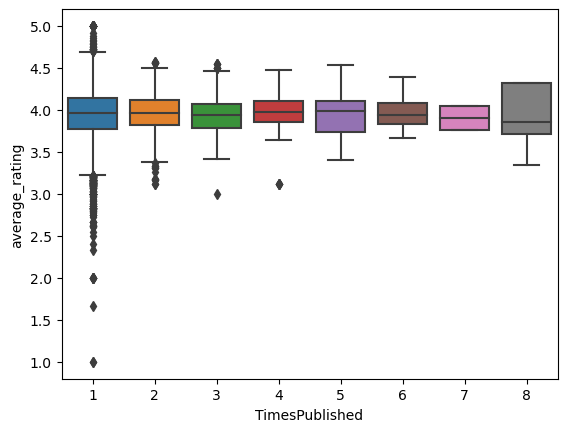

In [41]:
sns.boxplot(x="TimesPublished", y="average_rating", data=df)
print("Correlation between TimesPublished and Average_Rating:")

It doesn't seem that books that were publihsed more than once have significantly better ratings than those that were published only once. So we decide to not include this feature.

- Engagement Rate: 

We have seen in EDA that books with higher reviews to rating_counts have slightly better average_ratings. So, we'll include this feature to our dataset.

In [42]:
df["ER"] = 100 * df.text_reviews_count / (df.ratings_count + 1)

In [43]:
# Create new hot encoded feature from language_code 
df = pd.get_dummies(df, columns=['language_code'], prefix='Lang')

In [44]:
# Create new hot encoded feature from authors 
df = pd.get_dummies(df, columns=['Author'], prefix='Author')

In [45]:
# Create new hot encoded feature from publishers 
df = pd.get_dummies(df, columns=['publisher'], prefix='publisher')

2. Feature Pruning

Some common examples of feature pruning methods include:

    - Removing features with low variance
    - Removing features with low correlation to the target variable
    - Recursive Feature Elimination (RFE)
    - Lasso regularization
    - K-Best Method

We'll use the K-Best method as it will help us easily find the most impactful features to our analysis and also reduce the dimensionality of our dataset.

According to the K-Best algorithm, the 50 most important features are  the following : 

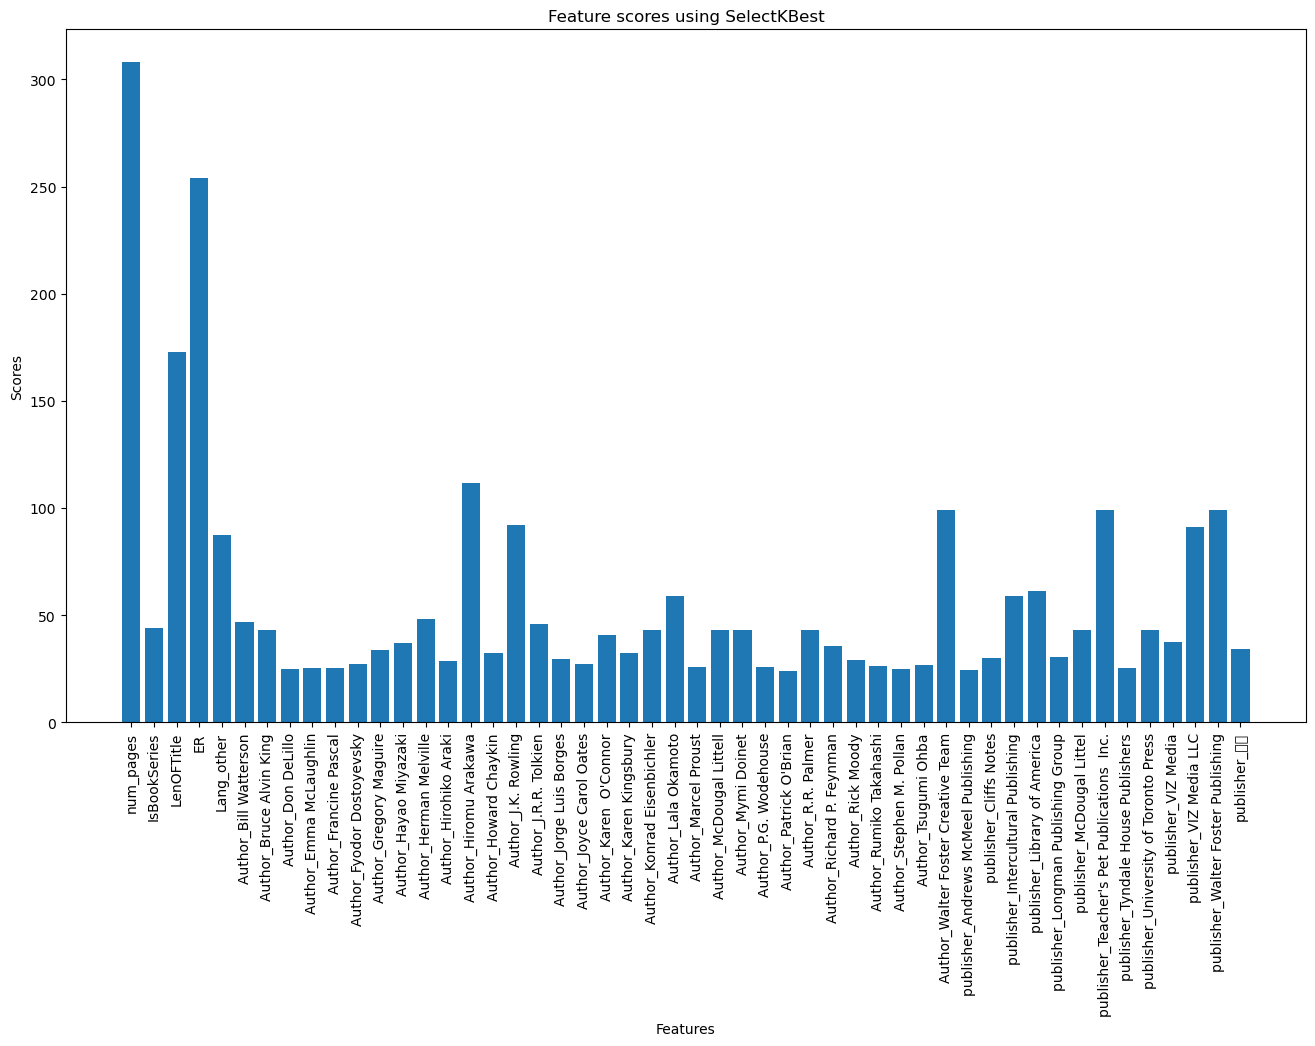

In [46]:
# Drop the columns we won't use 
columns_to_exclude = ['bookID', 'title', 'isbn', 'isbn13', 'publication_date', "authors", "average_rating"]
features_to_use = df.drop(columns_to_exclude, axis=1).columns
# Split your data into feature and target arrays
X = df[features_to_use]
y = df['average_rating']

# Use SelectKBest to perform feature selection
kbest = SelectKBest(f_regression, k=50)
X_new = kbest.fit_transform(X, y)

# Get the indices of the selected features and their scores
selected_feature_indices = kbest.get_support(indices=True)
selected_feature_scores = kbest.scores_[selected_feature_indices]


# Plot the scores as a bar plot
plt.figure(figsize=(16,9))
plt.bar(np.arange(len(selected_feature_scores)), selected_feature_scores)
plt.xticks(np.arange(len(selected_feature_scores)), X.columns[selected_feature_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.title("Feature scores using SelectKBest")
plt.show()

- Choice justification : 

Some of the features that we have created in the feature engineering part have some predictive power while some others don't. For example, ER, Length of Title have gotten the highest scores.

In [47]:
# Set features to use for prediction 
features_to_use = X.columns[selected_feature_indices].to_list()

### II) MODEL TRAINING

In [48]:
# This function will make training models easier
def trainandtest(df, model, features, target):
    # Drop na
    df.dropna(inplace=True)
    # Set X and y
    X = df[features]
    y = df[target]

    # Init model
    model_ = model()
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .25, random_state = 25)
    # Fit model to data
    model_.fit(X_train, y_train)
    # Predicting R2 Score the Train set results
    y_pred_train = model_.predict(X_train)
    r2_score_train = r2_score(y_train, y_pred_train)
    # Predicting R2 Score the Test set results
    y_pred_test = model_.predict(X_test)
    r2_score_test = r2_score(y_test, y_pred_test)
    scores = cross_val_score(model_, X_train, y_train, cv=3)
    scores = scores.mean()
    return r2_score_train, r2_score_test, scores


In [49]:
# This function evaluates each model and outputs a pandas dataframe with corresponding results
def eval_func(df, models, features_to_use):
    Results = []
    for model in models:
        result = {}
        r2_score_train, r2_score_test, scores = trainandtest(df, model, features_to_use ,"average_rating")
        result["ModelName"] = model.__name__ 
        result["Train_Score (R2)"] = round(r2_score_train,2)
        result["Test_Score (R2)"] = round(r2_score_test,2)
        result["Mean_CV_Score (R2)"] = round(scores,2)
        Results.append(result) 
    # Store Results in DataFrame
    ModelsResult = pd.DataFrame(Results)
    return ModelsResult

We choose to moblize 3 models : LinearRegression, RandomForestRegressor and GradientBoostingRegressor. The reason why we chose these models is because we're trying to predict a feature which is numerical type so this is basically a regression problem. 

In [50]:
# Models to use 
models = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor]
results = eval_func(df, models, features_to_use)
results.sort_values(by=["Mean_CV_Score (R2)", "Train_Score (R2)"], ascending=False)

,ModelName,Train_Score (R2),Test_Score (R2),Mean_CV_Score (R2)
2,GradientBoostingRegressor,0.24,0.17,0.16
0,LinearRegression,0.21,0.13,0.14
1,RandomForestRegressor,0.87,0.10,0.08


Models are peforming poorly. The RandomForestRegressor does a great job at the training data but performs very poorly at the test data.

- Let's use additional ressources and enrich our dataset with a new feature which is the genre. 

In [51]:
# # Getting Genres Data
genres_df = pd.read_json(r'C:\Users\flash\Documents\Book_Rating_Prediction_App\goodreads_book_genres_initial.json', lines=True)
# # Raname column bookid
genres_df = genres_df.rename(columns={"book_id": "bookID"})

In [52]:
# This dataset is huge, we're going to use it for getting the genres of books in our original dataset
genres_df.shape

(2360655, 2)

In [53]:
# # Join data with genres table
merged_genre = pd.merge(df, genres_df, how="left", on="bookID")
# Clean the Genre column
merged_genre["Genre"] = merged_genre.genres.apply(lambda x: list(x)[0] if type(x) == dict and len(x)>0 else np.nan)
# Create new hot encoded feature from genre 
merged_genre = pd.get_dummies(merged_genre, columns=['Genre'], prefix='Genre')

In [54]:
features_to_use = features_to_use + ['Genre_children',
       'Genre_comics, graphic', 'Genre_fantasy, paranormal', 'Genre_fiction',
       'Genre_history, historical fiction, biography',
       'Genre_mystery, thriller, crime', 'Genre_non-fiction', 'Genre_poetry',
       'Genre_romance', 'Genre_young-adult']

In [55]:
# Retrain models
models = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor]
results = eval_func(merged_genre,models, features_to_use)
results.sort_values(by=["Mean_CV_Score (R2)", "Train_Score (R2)"], ascending=False)

,ModelName,Train_Score (R2),Test_Score (R2),Mean_CV_Score (R2)
2,GradientBoostingRegressor,0.28,0.25,0.24
0,LinearRegression,0.22,0.22,0.20
1,RandomForestRegressor,0.89,0.19,0.18


The genre feature slightly improved our models but still this performance is quite low.

In [56]:
# Import reviews data
# def read_gz_file_to_df(file_path):
#     with gzip.open(file_path, "rt") as f:
#         df = pd.DataFrame(
#             [json.loads(line) for line in f]
#         )
#     return df

reviews_df = pd.read_csv("D:\Book_Genre_Data\reviewsDF.csv")


In [57]:
# Get neceassary cols
reviews_df = reviews_df[["bookID", "review_sentences"]]

In [58]:
# Shape of reviews_df
reviews_df.shape

(1378033, 2)

In [59]:
# We can observe duplicate bookIDs in this dataset, it's because one book can have multiple reviews
reviews_df[reviews_df.drop("bookID",axis=1).duplicated() == True].sort_values(by="bookID")

,bookID,review_sentences
1291086,1,"[[0, 'Reviews will be after this month due to ..."
861180,1,"[[0, 'Reread']]"
720760,1,"[[0, 'Powerful.']]"
467025,1,"[[0, 'Best of the series.']]"
409480,1,"[[0, 'So, I wrote a review for this when I rea..."
...,...,...
1035874,35506986,"[[0, 'Review to come']]"
975827,35575668,"[[0, 'Review to come!']]"
906830,35652776,"[[0, 'Absolutely brilliant!']]"
42935,35696559,"[[0, 'Loved it!']]"


In [60]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378033 entries, 0 to 1378032
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   bookID            1378033 non-null  int64 
 1   review_sentences  1378033 non-null  object
dtypes: int64(1), object(1)
memory usage: 21.0+ MB


In [61]:
# Merging datasets
merged_genre_reviews = pd.merge(merged_genre, reviews_df, how="left", on="bookID")

In [62]:
merged_genre_reviews.shape

(91613, 6503)

In [63]:
# Not all books have reivews
merged_genre_reviews.review_sentences = merged_genre_reviews.review_sentences.fillna("Review is not available")

In [64]:
merged_genre_reviews.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,"Genre_comics, graphic","Genre_fantasy, paranormal",Genre_fiction,"Genre_history, historical fiction, biography","Genre_mystery, thriller, crime",Genre_non-fiction,Genre_poetry,Genre_romance,Genre_young-adult,review_sentences
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,0,1,0,0,0,0,0,0,0,"[[0, 'One of the best books in the series I th..."
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,0,1,0,0,0,0,0,0,0,"[[0, 'It only gets better as the suspense buil..."


In [65]:
# Clean the review_text column
def extract_text(df, column_name):
    df['text'] = df[column_name].apply(lambda x: " ".join([sentence[1] for sentence in ast.literal_eval(x)]) if x != "Review is not available" else "Review is not available")
    return df

In [66]:
merged_genre_reviews_cleaned = extract_text(merged_genre_reviews, "review_sentences")

In [67]:
merged_genre_reviews_cleaned

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,"Genre_fantasy, paranormal",Genre_fiction,"Genre_history, historical fiction, biography","Genre_mystery, thriller, crime",Genre_non-fiction,Genre_poetry,Genre_romance,Genre_young-adult,review_sentences,text
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,"[[0, 'One of the best books in the series I th...",One of the best books in the series I think.
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,"[[0, 'It only gets better as the suspense buil...",It only gets better as the suspense builds in ...
2,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,"[[0, 'First of all, Im in love with these book...","First of all, Im in love with these books sinc..."
3,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,"[[0, ""This book didn't disappoint me at all.""]...",This book didn't disappoint me at all. I absol...
4,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,"[[0, 'Urgh.']]",Urgh.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91608,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,512,156,20,2004-12-21,...,0,1,0,0,0,0,0,0,Review is not available,Review is not available
91609,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,635,783,56,1988-12-01,...,0,1,0,0,0,0,0,0,Review is not available,Review is not available
91610,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,415,820,95,1993-08-01,...,0,1,0,0,0,0,0,0,Review is not available,Review is not available
91611,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,434,769,139,2007-02-27,...,0,0,0,0,1,0,0,0,Review is not available,Review is not available


In [68]:
# We'll have to do some data cleaning, I'll group all the books by their IDs and concatenate the reviews for each book
# Group the data by bookID and concatenate the review_sentences
# Group the data by bookID and concatenate the Text
grouped_reviews = merged_genre_reviews_cleaned.groupby('bookID')['text'].apply(lambda x: ' '.join(x))
# Reset the index and rename the column
grouped_reviews = grouped_reviews.reset_index().rename(columns={'text': 'concatenated_reviews'})

In [69]:
grouped_reviews

,bookID,concatenated_reviews
0,1,One of the best books in the series I think. I...
1,2,"After the first read, this book is the worst o..."
2,4,Review is not available
3,5,This one definitely wasn't as good as the seco...
4,8,Review is not available
...,...,...
9299,45631,Review is not available
9300,45633,Review is not available
9301,45634,Review is not available
9302,45639,Review is not available


In [70]:
# Join data with genres table
merged_genre_reviews = pd.merge(merged_genre, grouped_reviews, how="left", on="bookID")

In [71]:
merged_genre_reviews.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,"Genre_comics, graphic","Genre_fantasy, paranormal",Genre_fiction,"Genre_history, historical fiction, biography","Genre_mystery, thriller, crime",Genre_non-fiction,Genre_poetry,Genre_romance,Genre_young-adult,concatenated_reviews
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,0,1,0,0,0,0,0,0,0,One of the best books in the series I think. I...
1,2005,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0747584664,9780747584667,768,1213,78,2006-06-23,...,0,1,0,0,0,0,0,0,0,Review is not available


In [72]:
# Run sentiment analysis on reviews
merged_genre_reviews['sentiment_score'] = merged_genre_reviews['concatenated_reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [73]:
merged_genre_reviews.head(2)

,bookID,title,authors,average_rating,isbn,isbn13,num_pages,ratings_count,text_reviews_count,publication_date,...,"Genre_fantasy, paranormal",Genre_fiction,"Genre_history, historical fiction, biography","Genre_mystery, thriller, crime",Genre_non-fiction,Genre_poetry,Genre_romance,Genre_young-adult,concatenated_reviews,sentiment_score
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,652,2095690,27591,2006-09-16,...,1,0,0,0,0,0,0,0,One of the best books in the series I think. I...,0.142976
1,2005,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.57,0747584664,9780747584667,768,1213,78,2006-06-23,...,1,0,0,0,0,0,0,0,Review is not available,-0.200000


In [74]:
# Review is not available got a negative score, we'll replace it with 0
merged_genre_reviews.loc[merged_genre_reviews[merged_genre_reviews.concatenated_reviews == "Review is not available"].index , "sentiment_score"] = 0


In [75]:
# Give labels to sentiement_score
def sentiment_label(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

merged_genre_reviews['sentiment_label'] = merged_genre_reviews['sentiment_score'].apply(lambda x: sentiment_label(x))


<AxesSubplot:xlabel='sentiment_score', ylabel='Count'>

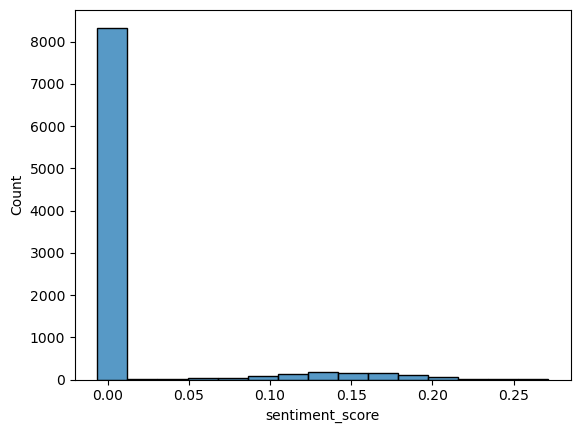

In [76]:
sns.histplot(merged_genre_reviews.sentiment_score)

Most reveiws are neutral

In [77]:
# Create new hot encoded feature from genre 
merged_genre_reviews = pd.get_dummies(merged_genre_reviews, columns=['sentiment_label'], prefix='sentiment_label')

In [78]:
features_to_use = features_to_use + ['sentiment_label_Negative',
       'sentiment_label_Neutral', 'sentiment_label_Positive']

In [79]:
# Retrain models
models = [LinearRegression, RandomForestRegressor, GradientBoostingRegressor]
results = eval_func(merged_genre_reviews,models, features_to_use)
results.sort_values(by=["Mean_CV_Score (R2)", "Train_Score (R2)"], ascending=False)

,ModelName,Train_Score (R2),Test_Score (R2),Mean_CV_Score (R2)
2,GradientBoostingRegressor,0.28,0.25,0.24
0,LinearRegression,0.22,0.22,0.20
1,RandomForestRegressor,0.89,0.20,0.19


Adding reviews text didn't really help improving the accuracy of models.

### Conclusion

The average_rating of a book is determined by multiple factors and the analysis showed some interesting insights. Predicting this feature revealed to be a real challenge.